In [1]:
using Thebes, Luxor, LightXML, NLsolve

In [2]:
O3D = Point3D(0, 0, 0)
O2D = pin(O3D, gfunction=(p3, p2) -> nothing)
pointradius = 3
linewidth = 2;

In [3]:
function textlabel!(parent, txt::AbstractString, pos::Point; xoffset::Number=0, yoffset::Number=0)
    x = pos.x + xoffset + top_left_corner.x
    y = pos.y + yoffset + top_left_corner.y
    elem = new_child(parent, "text")
    add_text(elem, txt)
    set_attributes(elem, Dict("class"=>"math", "x"=>string(x, "pt"), "y"=>string(y, "pt")))
    return nothing
end;

function myarrow(p3d, p2d)
    arrow(first(p2d), last(p2d), linewidth=linewidth)
end

myarrow (generic function with 1 method)

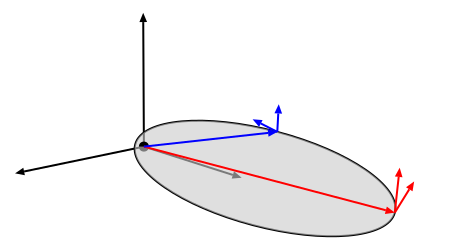

In [4]:
drawing_height = 250
Drawing(450, drawing_height, :svg)
helloworld()
origin()
# setcolor("black")
# box(Point(0,0), 450, drawing_height, :stroke)
eyepoint(6, 6, 2)
centerpoint(-9, -8, -2.5)
perspective(500)

plist = [
    Point3D(1, -1, 0),
    Point3D(4, 4, 0),
    Point3D(-1, 4, 0),
    Point3D(-1, -1, 0)
]
points = project.(plist)
ecenter, emajor, eminor, erotation = ellipseinquad(points, :none)

semilatus = sqrt(emajor^2 - eminor^2)
occupied_focus = ecenter - Point(semilatus*cos(erotation), semilatus*sin(erotation))

proj = newprojection(eyepoint(), centerpoint(), uppoint(), perspective())

function nlsolvewrapper(target::Point)
    function f!(F, x)
        F[1] = (proj.U.x * x[1] + proj.U.y * x[2] - proj.ue) * x[3] - target.x
        F[2] = (proj.V.x * x[1] + proj.V.y * x[2] - proj.ve) * x[3] + target.y
        r = proj.W.x * x[1] + proj.W.y * x[2] - proj.we
        F[3] = x[3] - proj.perspective / r
    end
    sol = nlsolve(f!, [0.1; 0.1; 100])
    return sol
end

sol = nlsolvewrapper(occupied_focus)
occupied_focus_3D = Point3D(sol.zero[1], sol.zero[2], 0)

setcolor("black")
pin(occupied_focus_3D, gfunction=(_, p2) -> pie(p2, 5, 0, pi, :fill))

# Axes
setcolor("black")
_, X = pin(occupied_focus_3D, occupied_focus_3D + Point3D(2, 0, 0), gfunction=myarrow)
_, Y = pin(occupied_focus_3D, occupied_focus_3D + Point3D(0, 2, 0), gfunction=myarrow)
_, Z = pin(occupied_focus_3D, occupied_focus_3D + Point3D(0, 0, 2), gfunction=myarrow)

setcolor("black")
ellipseinquad(points, :strokepreserve)
setcolor((0.8, 0.8, 0.8, 0.6))
fillpath()

setcolor("black")
pin(occupied_focus_3D, gfunction=(_, p2) -> pie(p2, 5, pi, 0, :fill))

# Position 1
setcolor("red")
ellipse_vertex = Point(emajor*cos(erotation), emajor*sin(erotation)) + ecenter
sol = nlsolvewrapper(ellipse_vertex)
ellipse_vertex_3D = Point3D(sol.zero[1], sol.zero[2], 0)
# Position
pin(occupied_focus_3D, ellipse_vertex_3D, gfunction=myarrow)
# Velocity
_, dotr_1 = pin(ellipse_vertex_3D, ellipse_vertex_3D - Point3D(1.2, 0.3, 0), gfunction=myarrow)
# Angular momentum
_, h_1 = pin(ellipse_vertex_3D, ellipse_vertex_3D + Point3D(0, 0, 0.5), gfunction=myarrow)

# Position 2
setcolor("blue")
ellipse_covertex = Point(eminor*sin(erotation), -eminor*cos(erotation)) + ecenter
sol = nlsolvewrapper(ellipse_covertex)
ellipse_covertex_3D = Point3D(sol.zero[1], sol.zero[2], 0)
# Position
pin(occupied_focus_3D, ellipse_covertex_3D, gfunction=myarrow)
# Velocity
_, dotr_2 = pin(ellipse_covertex_3D, ellipse_covertex_3D - Point3D(0.5, 1, 0), gfunction=myarrow)
# Angular momentum
_, h_2 = pin(ellipse_covertex_3D, ellipse_covertex_3D + Point3D(0, 0, 0.5), gfunction=myarrow)

top_left_corner = getworldposition(Point(0, 0), centered=false)
finish()
preview()

In [5]:
svg_out = svgstring();
xdoc = parse_string(svg_out)
xroot = root(xdoc);

In [6]:
textlabel!(xroot, "\\boldsymbol{r}_1", between(occupied_focus, ellipse_vertex, 0.4), yoffset=-20)
textlabel!(xroot, "\\dot{\\boldsymbol{r}}_1", dotr_1, xoffset=-105, yoffset=-60)
textlabel!(xroot, "\\boldsymbol{h}_1", h_1, xoffset=-110, yoffset=-55)

textlabel!(xroot, "\\boldsymbol{r}_2", between(occupied_focus, ellipse_covertex, 0.4), xoffset=-20, yoffset=-35)
textlabel!(xroot, "\\dot{\\boldsymbol{r}}_2", dotr_2, xoffset=-65, yoffset=-40)
textlabel!(xroot, "\\boldsymbol{h}_2", h_2, xoffset=-80, yoffset=-40)

textlabel!(xroot, "x", X, yoffset=-40)
textlabel!(xroot, "y", Y, xoffset=-65, yoffset=-40)
textlabel!(xroot, "z", Z, xoffset=-48, yoffset=10)

In [7]:
save_file(xdoc, "../raw_svg/orbital-angular-momentum.svg");